CALIBRATION ANALYSIS
Brier Score (Val):  0.0000
Brier Score (Test): 0.0006
Expected Calibration Error (Val):  0.0004
Expected Calibration Error (Test): 0.0016


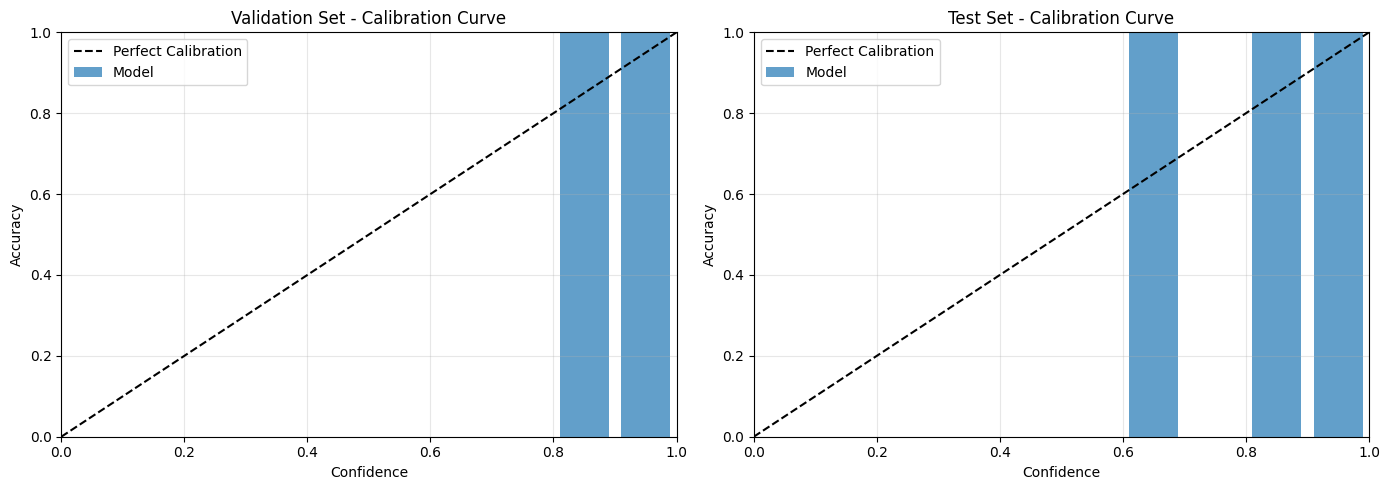

UNCERTAINTY TRIAGE ANALYSIS
Confidence < 0.50:    0 flagged (  0.0%), Accuracy on flagged: 1.0000
Confidence < 0.55:    0 flagged (  0.0%), Accuracy on flagged: 1.0000
Confidence < 0.60:    0 flagged (  0.0%), Accuracy on flagged: 1.0000
Confidence < 0.65:    0 flagged (  0.0%), Accuracy on flagged: 1.0000
Confidence < 0.70:    2 flagged (  0.1%), Accuracy on flagged: 1.0000
Confidence < 0.75:    2 flagged (  0.1%), Accuracy on flagged: 1.0000
Confidence < 0.80:    3 flagged (  0.2%), Accuracy on flagged: 0.6667
Confidence < 0.85:    3 flagged (  0.2%), Accuracy on flagged: 0.6667
Confidence < 0.90:    6 flagged (  0.4%), Accuracy on flagged: 0.8333
Confidence < 0.95:    8 flagged (  0.5%), Accuracy on flagged: 0.8750


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import os
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate dataset class
class KidneyDataset(Dataset):
    def __init__(self, labels_list, data_dir, transform=None):
        self.labels_list = labels_list
        self.data_dir = data_dir
        self.transform = transform
        self.label_to_idx = {'kidney_normal': 0, 'kidney_tumor': 1}
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        item = self.labels_list[idx]
        img_path = os.path.join(self.data_dir, item['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[item['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load labels
with open('data/val_labels.json', 'r') as f:
    val_labels = json.load(f)
with open('data/test_labels.json', 'r') as f:
    test_labels = json.load(f)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_dataset = KidneyDataset(val_labels, 'data/val', val_transform)
test_dataset = KidneyDataset(test_labels, 'data/test', val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model = model.to(device)
model.eval()

# Get predictions on validation set
def get_predictions(model, loader, device):
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)


val_preds, val_probs, val_labels = get_predictions(model, val_loader, device)
test_preds, test_probs, test_labels = get_predictions(model, test_loader, device)

# Calculate confidence and correctness
val_confidence = np.max(val_probs, axis=1)
val_correct = (val_preds == val_labels).astype(int)

test_confidence = np.max(test_probs, axis=1)
test_correct = (test_preds == test_labels).astype(int)

# Calibration analysis

print("CALIBRATION ANALYSIS")


# Brier score (lower is better)
val_brier = brier_score_loss(val_labels, val_probs[:, 1])
test_brier = brier_score_loss(test_labels, test_probs[:, 1])

print(f"Brier Score (Val):  {val_brier:.4f}")
print(f"Brier Score (Test): {test_brier:.4f}")

# Expected Calibration Error (ECE)
def calculate_ece(probs, labels, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_accs = []
    bin_confs = []
    bin_counts = []
    
    for i in range(n_bins):
        mask = (probs >= bin_edges[i]) & (probs < bin_edges[i+1])
        if mask.sum() > 0:
            bin_accs.append(labels[mask].mean())
            bin_confs.append(probs[mask].mean())
            bin_counts.append(mask.sum())
    
    ece = np.sum([abs(acc - conf) * count / len(probs) 
                  for acc, conf, count in zip(bin_accs, bin_confs, bin_counts)])
    return ece

val_ece = calculate_ece(val_confidence, val_correct)
test_ece = calculate_ece(test_confidence, test_correct)

print(f"Expected Calibration Error (Val):  {val_ece:.4f}")
print(f"Expected Calibration Error (Test): {test_ece:.4f}")

# Reliability diagram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (confidence, correct, title) in enumerate([
    (val_confidence, val_correct, 'Validation Set'),
    (test_confidence, test_correct, 'Test Set')
]):
    bin_edges = np.linspace(0, 1, 11)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_accs = []
    bin_counts = []
    
    for i in range(10):
        mask = (confidence >= bin_edges[i]) & (confidence < bin_edges[i+1])
        if mask.sum() > 0:
            bin_accs.append(correct[mask].mean())
            bin_counts.append(mask.sum())
        else:
            bin_accs.append(0)
            bin_counts.append(0)
    
    axes[idx].bar(bin_centers, bin_accs, width=0.08, alpha=0.7, label='Model')
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    axes[idx].set_xlabel('Confidence')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'{title} - Calibration Curve')
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/calibration_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Uncertainty threshold analysis

print("UNCERTAINTY TRIAGE ANALYSIS")


thresholds = np.arange(0.5, 1.0, 0.05)
for threshold in thresholds:
    flagged = (test_confidence < threshold).sum()
    flagged_acc = test_correct[test_confidence < threshold].mean() if flagged > 0 else 1.0
    
    print(f"Confidence < {threshold:.2f}: {flagged:4d} flagged ({flagged/len(test_confidence)*100:5.1f}%), "
          f"Accuracy on flagged: {flagged_acc:.4f}")

# Save uncertainty analysis
uncertainty_data = {
    'test_confidence': test_confidence.tolist(),
    'test_correct': test_correct.tolist(),
    'test_preds': test_preds.tolist(),
    'test_labels': test_labels.tolist(),
    'brier_score': float(test_brier),
    'ece': float(test_ece)
}

with open('results/uncertainty_analysis.json', 'w') as f:
    json.dump(uncertainty_data, f)
